In [2]:
import sys
import random
import pickle

import pandas as pd
import numpy as np
import json
from konlpy.tag import Twitter
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

from sklearn.naive_bayes import MultinomialNB , GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [5]:
import matplotlib.pyplot as plt

In [3]:
# read train data
with open('/elice/data/train_data.json') as fp:
    json_str = fp.read()
    json_data = json.loads(json_str)
    
train_df = pd.DataFrame(json_data, columns=['date','name','open','close','high','low','vol'])

with open('/elice/data/grading.input.txt') as fp:
    sbm_in = fp.read()
    sbm_in = sbm_in.splitlines()
    
t_x = train_df[['date']][train_df['name']==sbm_in[-1]]
t_x = t_x['date'].map(lambda x: ''.join(x.split('-')))
t_y = train_df[['close']][train_df['name']==sbm_in[-1]]

In [11]:
train_df[train_df['name']==sbm_in[-1]]

,date,name,open,close,high,low,vol
788762,2016-07-05,leaf,49.499,48.718,48.486,54.305,6223835
789262,2016-07-06,leaf,47.102,47.720,46.281,48.547,6697444
789762,2016-07-07,leaf,47.622,47.734,47.307,48.050,5491222
790262,2016-07-08,leaf,47.858,50.238,47.529,50.622,4240514
790762,2016-07-11,leaf,49.203,51.182,48.954,51.194,6053174
791262,2016-07-12,leaf,51.045,50.621,50.304,51.171,5546889
791762,2016-07-13,leaf,50.468,50.642,49.805,51.150,4865023
792262,2016-07-14,leaf,50.237,51.693,49.918,51.770,3478451
792762,2016-07-15,leaf,51.693,51.181,50.519,51.894,3692362
793262,2016-07-18,leaf,50.810,51.363,50.616,51.531,1556989


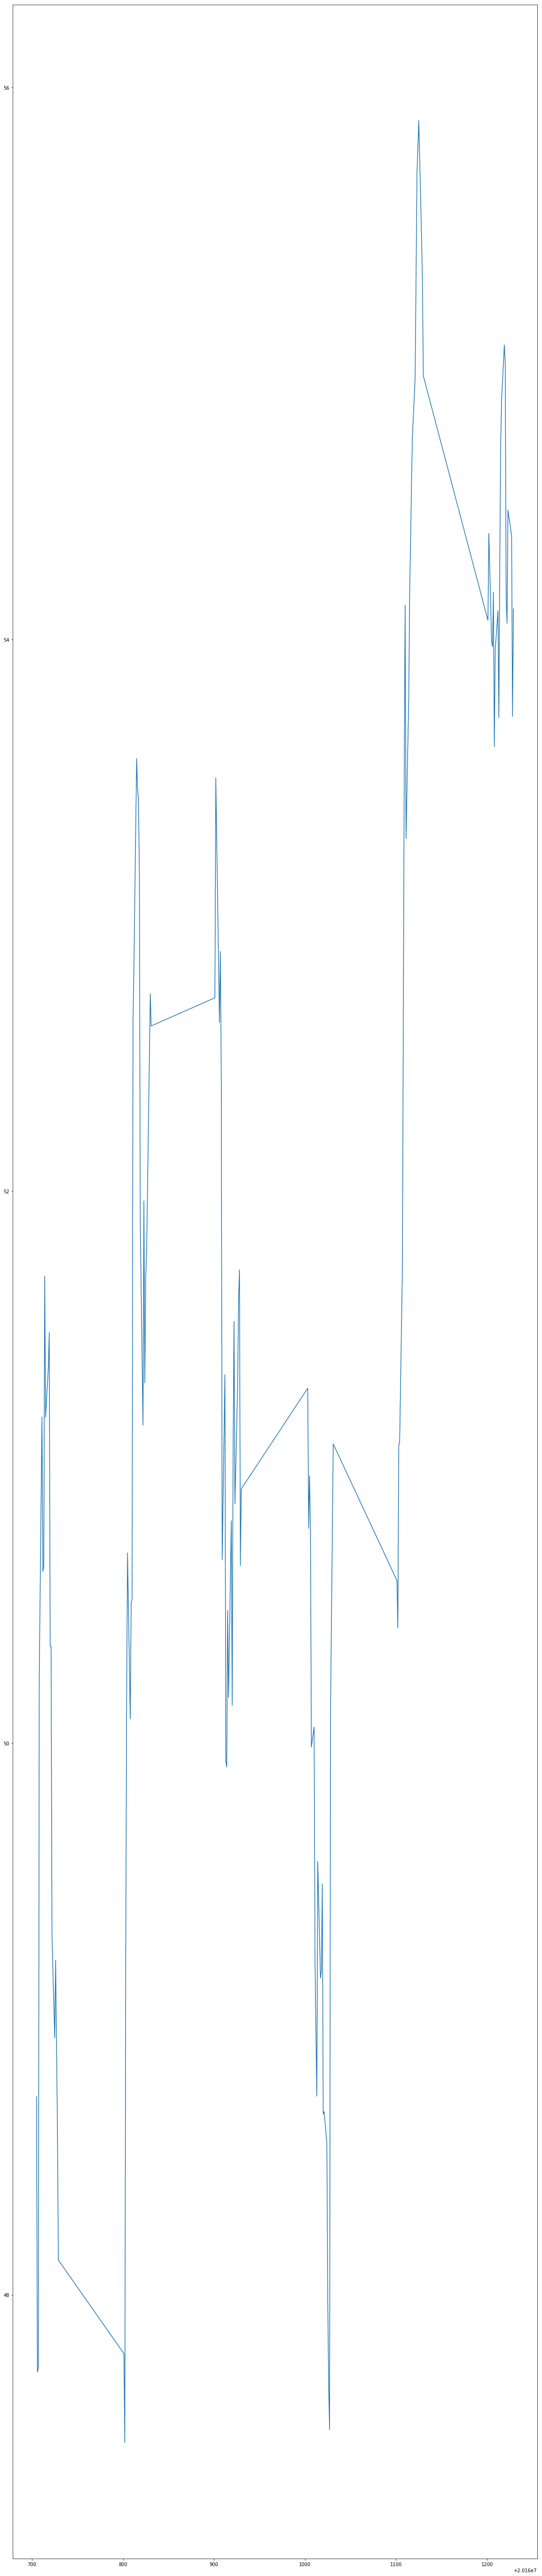

In [12]:
plt.figure(figsize=[20,100])
plt.plot(t_x, t_y)
plt.show()